# **Import/Preprocessing (training)**



## Import/CSV processing

In [313]:
import sys  
!{sys.executable} -m pip install contractions

In [314]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import os
from sklearn import svm
import contractions as cot
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import re
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
# Downloads library of stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
#for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from google.colab import drive
drive.mount('/content/drive') # Allows us to access the data
os.chdir("/content/drive/MyDrive/FakeNews") # Changes the directory to the folder with the csv files

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [315]:
fn = pd.read_csv("Fake.csv")
tn = pd.read_csv("True.csv")
fn['truth'] = 0
tn['truth'] = 1

In [316]:
tn.drop_duplicates(inplace=True)
fn.drop_duplicates(inplace=True)
fn['truth'].value_counts()

0    23478
Name: truth, dtype: int64

In [317]:
extra = pd.read_csv("/content/drive/MyDrive/archive8/politifact.csv")
extra = extra.drop(columns=['Unnamed: 0', 'sources', 'sources_dates', 'sources_post_location', 'curator_name', 'curated_date', 'curators_article_title','curator_complete_article', 'curator_tags','sources_url'])
extra.drop_duplicates(inplace=True)
extra.dropna(inplace=True)
extra['fact'].replace(['false', "pants-fire"], 0, inplace=True)
extra['fact'].replace(['true', 'mostly-true'], 1, inplace=True)
extra.drop(extra.loc[extra['fact']=="half-true"].index, inplace=True)
extra.drop(extra.loc[extra['fact']=="barely-true"].index, inplace=True)
extra.drop(extra.loc[extra['fact']=="full-flop"].index, inplace=True)
extra.drop(extra.loc[extra['fact']=="half-flip"].index, inplace=True)
extra.drop(extra.loc[extra['fact']=="no-flip"].index, inplace=True)

extra.rename(columns={'sources_quote': 'title', 'fact':'truth'},inplace=True)

In [318]:
def remove_lines(text):
  text = text.strip("\n")
  return text
extra['title'] = extra['title'].apply(lambda x:remove_lines(x))

extra['truth'].value_counts()
extra['text'] = extra['title']
extra.head()

,title,truth,text
0,Says Disneyland is enforcing a “no scream” pol...,0,Says Disneyland is enforcing a “no scream” pol...
1,Video “proves 100% that President Joe Biden is...,0,Video “proves 100% that President Joe Biden is...
2,“If you look at the average teacher pay compar...,1,“If you look at the average teacher pay compar...
5,“Pelosi’s $1.9 trillion bailout gives EVERY fe...,0,“Pelosi’s $1.9 trillion bailout gives EVERY fe...
6,“Black Lives Matter of Atlanta Charged with Wi...,0,“Black Lives Matter of Atlanta Charged with Wi...


In [319]:
fn = fn[:-2000]
fn.head()

,title,text,subject,date,truth
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [320]:
fn.rename(columns={0: "title", 1: "text", 2: "subject", 3: "date", 4: "truth" }, inplace=True)



In [321]:
news = pd.concat([tn, fn, extra], axis=0, ignore_index=True) # Combines the dataframes so its easier to work with


In [322]:
news.drop_duplicates(inplace=True)

In [323]:
news["truth"].value_counts()

0    28388
1    26850
Name: truth, dtype: int64

In [324]:
news

,title,text,subject,date,truth
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
55233,"In the House health care bill, ""Something like...","In the House health care bill, ""Something like...",NaN,NaN,0
55234,"""Ronald Reagan faced an even worse recession"" ...","""Ronald Reagan faced an even worse recession"" ...",NaN,NaN,0
55235,"The McCain campaign ""did not elaborate"" on Oba...","The McCain campaign ""did not elaborate"" on Oba...",NaN,NaN,0
55236,Obama has admitted a cap and trade plan would ...,Obama has admitted a cap and trade plan would ...,NaN,NaN,1


## Preprocessing


In [325]:
def remove_contractions(text):
  fixed_word = []
  for word in text.split():
    fixed_word.append(cot.fix(word))
  counter = 0
  for i in fixed_word:
    if i != fixed_word[0]:
      counter+=1
    if i == "you.S.":
      fixed_word[counter] = "u.s."
    if i == "yous":
      fixed_word[counter] = "u.s."
  fixed_whole =' '.join(fixed_word)
  return fixed_whole


news['title_wo_contra']=news['title'].apply(lambda x: remove_contractions(x))
news['text_wo_contra']=news['text'].apply(lambda x: remove_contractions(x))
news.head()

,title,text,subject,date,truth,title_wo_contra,text_wo_contra
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As u.s. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,u.s. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior u.s. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...


In [326]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

# Removes all the punctuation

news['title_wo_punct']=news['title_wo_contra'].apply(lambda x: remove_punctuation(x))
news['text_wo_punct']=news['text_wo_contra'].apply(lambda x: remove_punctuation(x))
news.head()

,title,text,subject,date,truth,title_wo_contra,text_wo_contra,title_wo_punct,text_wo_punct
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As u.s. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,As us budget fight looms Republicans flip thei...,WASHINGTON Reuters The head of a conservative...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,u.s. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,us military to accept transgender recruits on ...,WASHINGTON Reuters Transgender people will be...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior u.s. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,Senior us Republican senator Let Mr Mueller do...,WASHINGTON Reuters The special counsel invest...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,FBI Russia probe helped by Australian diplomat...,WASHINGTON Reuters Trump campaign adviser Geo...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,Trump wants Postal Service to charge much more...,SEATTLEWASHINGTON Reuters President Donald Tr...


In [327]:
def remove_stopwords(text):
    text = text.split()
    text=[word for word in text if word not in stopword]
    text= ' '.join(text)
    return text

news['title_wo_stopwords'] = news['title_wo_punct'].apply(lambda x: remove_stopwords(x.lower()))
news['text_wo_stopwords'] = news['text_wo_punct'].apply(lambda x: remove_stopwords(x.lower()))

news.head()

,title,text,subject,date,truth,title_wo_contra,text_wo_contra,title_wo_punct,text_wo_punct,title_wo_stopwords,text_wo_stopwords
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As u.s. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,As us budget fight looms Republicans flip thei...,WASHINGTON Reuters The head of a conservative...,us budget fight looms republicans flip fiscal ...,washington reuters head conservative republica...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,u.s. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,us military to accept transgender recruits on ...,WASHINGTON Reuters Transgender people will be...,us military accept transgender recruits monday...,washington reuters transgender people allowed ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior u.s. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,Senior us Republican senator Let Mr Mueller do...,WASHINGTON Reuters The special counsel invest...,senior us republican senator let mr mueller job,washington reuters special counsel investigati...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,FBI Russia probe helped by Australian diplomat...,WASHINGTON Reuters Trump campaign adviser Geo...,fbi russia probe helped australian diplomat ti...,washington reuters trump campaign adviser geor...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,Trump wants Postal Service to charge much more...,SEATTLEWASHINGTON Reuters President Donald Tr...,trump wants postal service charge much amazon ...,seattlewashington reuters president donald tru...


In [328]:
def remove_quotemarks(text):
  text = text.replace('“', "")
  text = text.replace('’', "")
  text = text.replace('”', "")
  return text
news['filtered_title'] =news['title_wo_stopwords'].apply(lambda x:remove_quotemarks(x)) 
news['filtered'] =news['text_wo_stopwords'].apply(lambda x:remove_quotemarks(x)) 
news['filtered']

0        washington reuters head conservative republica...
1        washington reuters transgender people allowed ...
2        washington reuters special counsel investigati...
3        washington reuters trump campaign adviser geor...
4        seattlewashington reuters president donald tru...
                               ...                        
55233    house health care bill something like 2 percen...
55234    ronald reagan faced even worse recession curre...
55235          mccain campaign elaborate obamas ties acorn
55236    obama admitted cap trade plan would electricit...
55237    says could take stimulus money required univer...
Name: filtered, Length: 55238, dtype: object

In [329]:
news["joined_title"] = news["filtered_title"]
news = news.drop(["title_wo_contra","title_wo_punct","title_wo_stopwords", "filtered_title"], axis=1)
news["joined_text"] = news["filtered"]
news = news.drop(["text_wo_contra","text_wo_punct","text_wo_stopwords", "filtered"], axis=1)
news.tail(10)
# Deletes all the excess columns and sets the title equal to the preprocessed version 

,title,text,subject,date,truth,joined_title,joined_text
55228,"Under the cap-and-trade bill, homes would have...","Under the cap-and-trade bill, homes would have...",NaN,NaN,0,capandtrade bill homes would retrofitted meet ...,capandtrade bill homes would retrofitted meet ...
55229,"Senate health care legislation will ""levy a ne...","Senate health care legislation will ""levy a ne...",NaN,NaN,0,senate health care legislation levy new aborti...,senate health care legislation levy new aborti...
55230,"The Senate health care bill ""would leave 24 mi...","The Senate health care bill ""would leave 24 mi...",NaN,NaN,1,senate health care bill would leave 24 million...,senate health care bill would leave 24 million...
55231,If you look at last year's presidential campai...,If you look at last year's presidential campai...,NaN,NaN,1,look last years presidential campaign cannot f...,look last years presidential campaign cannot f...
55232,"Obama has ""visited more countries and met with...","Obama has ""visited more countries and met with...",NaN,NaN,1,obama visited countries met world leaders pres...,obama visited countries met world leaders pres...
55233,"In the House health care bill, ""Something like...","In the House health care bill, ""Something like...",NaN,NaN,0,house health care bill something like 2 percen...,house health care bill something like 2 percen...
55234,"""Ronald Reagan faced an even worse recession"" ...","""Ronald Reagan faced an even worse recession"" ...",NaN,NaN,0,ronald reagan faced even worse recession curre...,ronald reagan faced even worse recession curre...
55235,"The McCain campaign ""did not elaborate"" on Oba...","The McCain campaign ""did not elaborate"" on Oba...",NaN,NaN,0,mccain campaign elaborate obamas ties acorn,mccain campaign elaborate obamas ties acorn
55236,Obama has admitted a cap and trade plan would ...,Obama has admitted a cap and trade plan would ...,NaN,NaN,1,obama admitted cap trade plan would electricit...,obama admitted cap trade plan would electricit...
55237,Says she couldn't take stimulus money because ...,Says she couldn't take stimulus money because ...,NaN,NaN,0,says could take stimulus money required univer...,says could take stimulus money required univer...


In [330]:
news.head(10)


,title,text,subject,date,truth,joined_title,joined_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,us budget fight looms republicans flip fiscal ...,washington reuters head conservative republica...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,us military accept transgender recruits monday...,washington reuters transgender people allowed ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,senior us republican senator let mr mueller job,washington reuters special counsel investigati...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,fbi russia probe helped australian diplomat ti...,washington reuters trump campaign adviser geor...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,trump wants postal service charge much amazon ...,seattlewashington reuters president donald tru...
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017",1,white house congress prepare talks spending im...,west palm beach flawashington reuters white ho...
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017",1,trump says russia probe fair timeline unclear nyt,west palm beach fla reuters president donald t...
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",1,factbox trump twitter dec 29 approval rating a...,following statements posted verified twitter a...
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017",1,trump twitter dec 28 global warming,following statements posted verified twitter a...
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017",1,alabama official certify senatorelect jones to...,washington reuters alabama secretary state joh...


## **Visualization**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


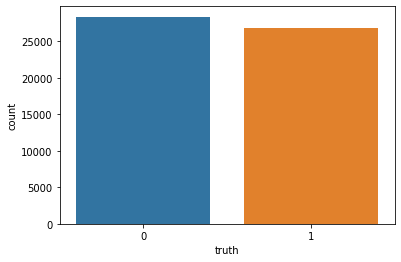

In [331]:
#@title Countplot
sns.countplot(news['truth'])


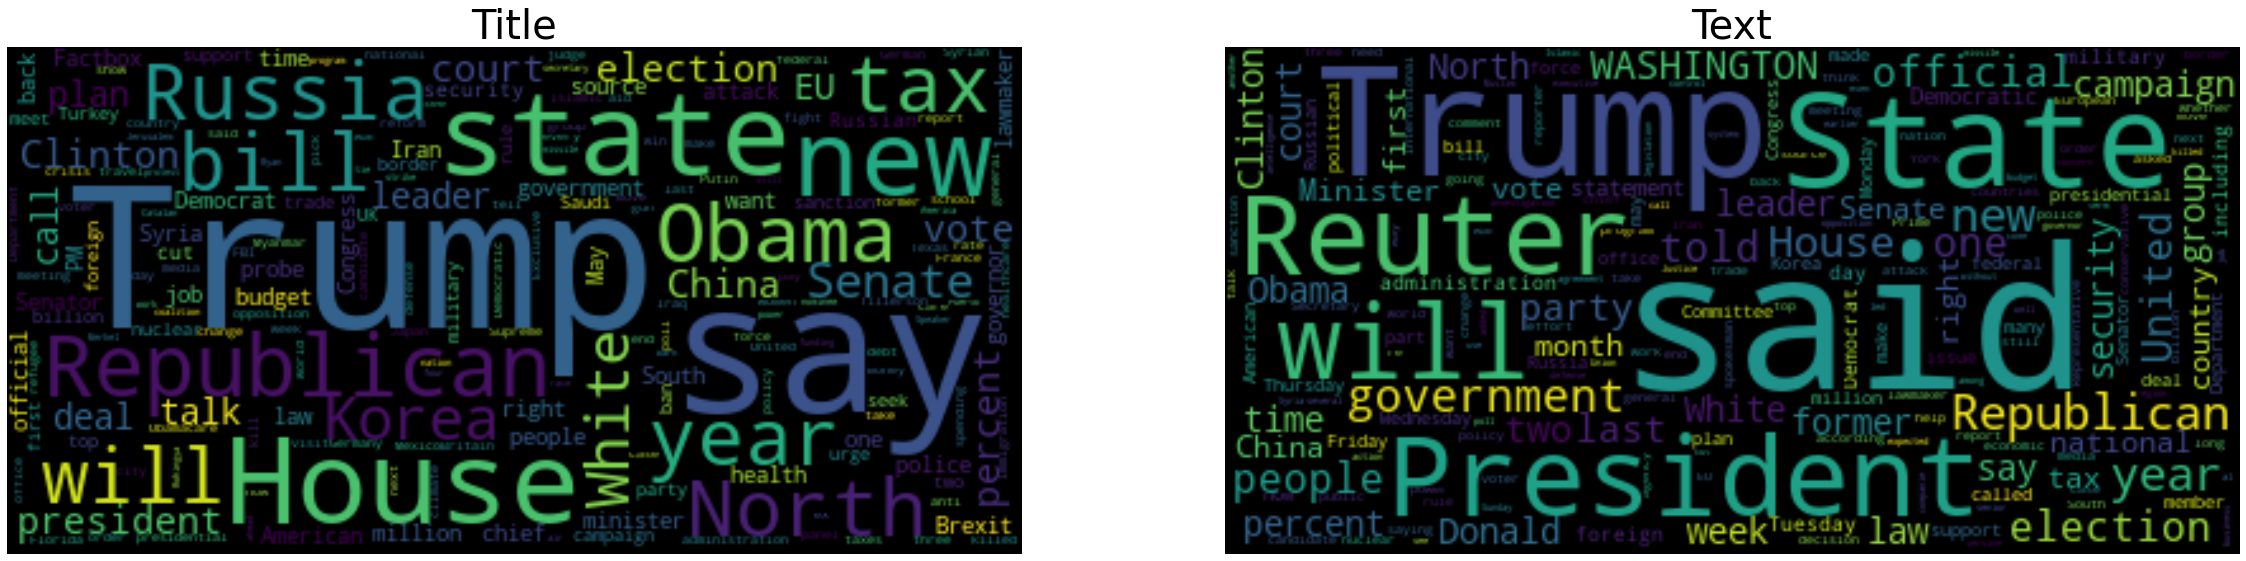

In [332]:
#@title
# Wordcloud of title, text in True news
import wordcloud
# Cleaned dataframe of True labels
df_true = news[news.truth == 1]

title_true = " ".join(tit for tit in df_true['title'])
text_true = " ".join(txt for txt in df_true['text'])

plt.figure(figsize=(40, 30))

# Title
title_cloud = wordcloud.WordCloud(collocations=False, background_color='black').generate(title_true)
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Title", fontsize=40)
plt.imshow(title_cloud, interpolation='bilinear')

# Title
text_cloud = wordcloud.WordCloud(collocations=False, background_color='black').generate(text_true)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Text", fontsize=40)
plt.imshow(text_cloud, interpolation='bilinear')


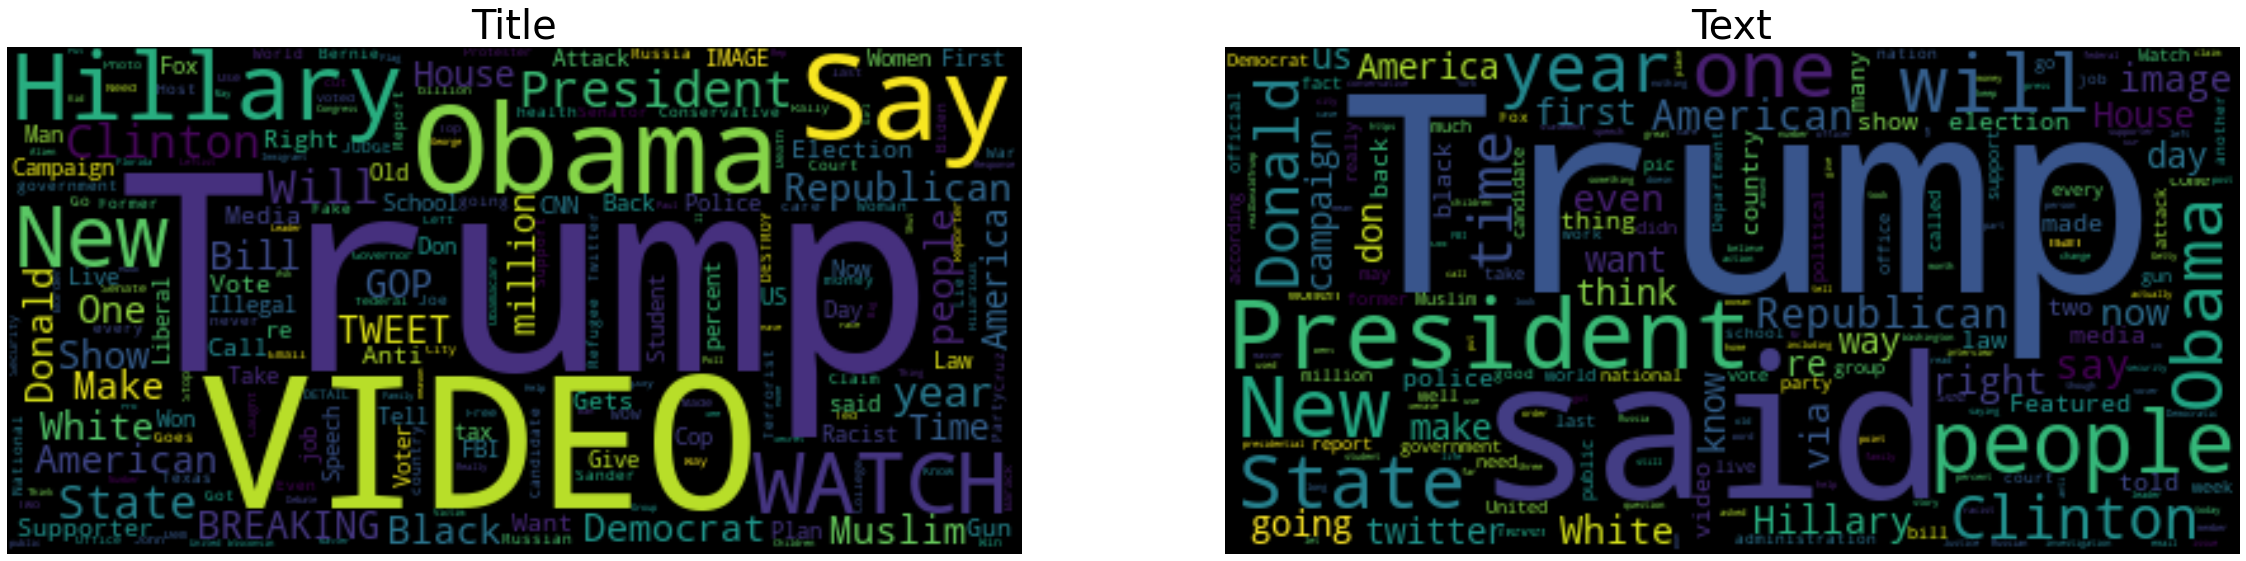

In [333]:
#@title
# Wordcloud of title, text in Fake news

# Cleaned dataframe of Fake labels

df_fake = news[news.truth == 0]

title_fake = " ".join(tit for tit in df_fake['title'])
text_fake = " ".join(txt for txt in df_fake['text'])

plt.figure(figsize=(40, 30))

# Title
title_cloud = wordcloud.WordCloud(collocations=False, background_color='black').generate(title_fake)
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Title", fontsize=40)
plt.imshow(title_cloud, interpolation='bilinear')

# Title
text_cloud = wordcloud.WordCloud(collocations=False, background_color='black').generate(text_fake)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Text", fontsize=40)
plt.imshow(text_cloud, interpolation='bilinear')

# **Model**

## **Vectorization/Model**

In [334]:
y = news['truth']
y = y.astype('int')
X = news['joined_text']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [335]:
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([('vect', TfidfVectorizer(ngram_range=(2,3), binary=True)),
                  ('tfidf', TfidfTransformer()),
                  ('clf', MultinomialNB())])


text_clf = text_clf.fit(X_train, y_train)


##**ML Model Scoring**

In [336]:
# Train score
text_clf.score(X_train, y_train)


0.9991174473862865

In [337]:
# Test score
text_clf.score(X_test, y_test)

0.8891202027516293

## **Precision and Recall Visualization**

In [338]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [339]:
y_predict_train = text_clf.predict(X_train)
y_predict_test = text_clf.predict(X_test)

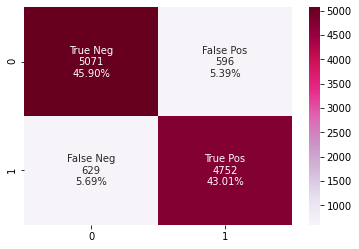

In [340]:
cm = confusion_matrix(y_test, y_predict_test)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='PuRd')

In [341]:
cr = classification_report(y_test, y_predict_test, output_dict= True)
cr = pd.DataFrame(cr).transpose()
cr

,precision,recall,f1-score,support
0,0.889649,0.894830,0.892232,5667.00000
1,0.888556,0.883107,0.885823,5381.00000
accuracy,0.889120,0.889120,0.889120,0.88912
macro avg,0.889103,0.888968,0.889028,11048.00000
weighted avg,0.889117,0.889120,0.889111,11048.00000


# **Input**

## **Input (manual)**

In [375]:
# Manual
text_sample = ["We have a record 9.3 million job openings in the U.S.", "You can vote below the age of 18", "Hillary Clinton won presidency"]
df = pd.DataFrame(text_sample, columns= ['text'])
df2 = df.copy()
df

,text
0,We have a record 9.3 million job openings in t...
1,You can vote below the age of 18
2,Hillary Clinton won presidency


In [343]:
text_clf.predict(text_sample)

array([0, 1, 0])

## **Input (scraped)**

In [489]:
from bs4 import BeautifulSoup
import urllib.request,sys,time
import requests
import pandas as pd
import re 
import time
import sys
import urllib
import numpy as np

In [490]:
page = ""
try:
  ton = int(input("What type of news to input into the model?:\n1: True\n2: Mostly True\n3: Half True\n4: Barely True\n5: False\n6: Extremely False\n"))
except ValueError:
  print("Enter a number!")
if ton == 1:
  page = "true"
elif ton == 2:
  page= 'mostly-true'
elif ton == 3:
  page= 'half-true'
elif ton == 4:
  page= 'barely-true'
elif ton == 5:
  page = 'false'
elif ton == 6:
  page = "pants-fire"

url = 'https://www.politifact.com/factchecks/list/?ruling='+ str(page)

print("Data source: "+ url)

What type of news to input into the model?:
1: True
2: Mostly True
3: Half True
4: Barely True
5: False
6: Extremely False
6
Data source: https://www.politifact.com/factchecks/list/?ruling=pants-fire


In [491]:
def getdata(url): 
    r = requests.get(url) 
    return r.text 

page = getdata(url)
soup = BeautifulSoup(page, "html.parser")


data = '' 
lst = []
for data in soup.find_all("div",attrs={"class":"m-statement__quote"}):
  lst.append(data.get_text()) 

new_list = [s.replace("\n", "") for s in lst]
res = []
for i in new_list:
    if i not in res:
        res.append(i)

In [492]:
if ton == 1:
  cat = ['true']
elif ton == 2:
  cat= ['mostly true']
elif ton == 3:
  cat= ['half true']
elif ton == 4:
  cat= ['barely true']
elif ton == 5:
  cat = ['false']
elif ton == 6:
  cat = ["extremely false"]

cat*=len(res)

d = {'text':res,'truth':cat}
df = pd.DataFrame(data = d)

In [493]:
df1 = df.copy()


# **Prediction**

## **Preprocessing (Input)**

same functions with slightly different changes

In [494]:
def remove_contractions(text):
  fixed_word = []
  for word in text.split():
    fixed_word.append(cot.fix(word))
  counter = 0
  for i in fixed_word:
    if i != fixed_word[0]:
      counter+=1
    if i == "you.S.":
      fixed_word[counter] = "u.s."
    if i == "yous":
      fixed_word[counter] = "u.s."
  fixed_whole =' '.join(fixed_word)
  return fixed_whole


df['text_wo_contra']=df['text'].apply(lambda x: remove_contractions(x))

In [495]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct
df['text_wo_punct']=df['text_wo_contra'].apply(lambda x: remove_punctuation(x))

In [496]:
def remove_stopwords(text):
    text = text.split()
    text=[word for word in text if word not in stopword]
    text= ' '.join(text)
    return text

df['text_wo_punct_wo_stopwords'] = df['text_wo_punct'].apply(lambda x: remove_stopwords(x.lower()))
df.head()

,text,truth,text_wo_contra,text_wo_punct,text_wo_punct_wo_stopwords
0,Says D.C. police officer Michael Fanone is the...,extremely false,Says D.C. police officer Michael Fanone is the...,Says DC police officer Michael Fanone is the s...,says dc police officer michael fanone person a...
1,The opening ceremony of the 2012 London Olympi...,extremely false,The opening ceremony of the 2012 London Olympi...,The opening ceremony of the 2012 London Olympi...,opening ceremony 2012 london olympics predicte...
2,“U.S. military holding White House for Trump’s...,extremely false,“you.S. military holding White House for Trump...,“youS military holding White House for Trump’s...,“yous military holding white house trump’s ret...
3,"""Kansas City Chiefs QB Patrick Mahomes has lef...",extremely false,"""Kansas City Chiefs QB Patrick Mahomes has lef...",Kansas City Chiefs QB Patrick Mahomes has left...,kansas city chiefs qb patrick mahomes left tra...
4,“Don’t believe the hype that Florida” COVID-19...,extremely false,“do not believe the hype that Florida” COVID-1...,“do not believe the hype that Florida” COVID19...,“do believe hype florida” covid19 “numbers bla...


In [497]:
def remove_quotemarks(text):
  text = text.replace('“', "")
  text = text.replace('’', "")
  text = text.replace('”', "")
  return text
df['filtered'] =df['text_wo_punct_wo_stopwords'].apply(lambda x:remove_quotemarks(x)) 
df['filtered']

0     says dc police officer michael fanone person a...
1     opening ceremony 2012 london olympics predicte...
2       yous military holding white house trumps return
3     kansas city chiefs qb patrick mahomes left tra...
4     do believe hype florida covid19 numbers blatan...
5     ambassador susan rice tribunal gavin newsom in...
6     queen elizabeth husband prince philip found gu...
7                                income taxes voluntary
8     seventy four thousand many mailin ballots rece...
9     arizona georgia proof joe biden not elected pr...
10    45000 confirmed dead covid19 shots within thre...
11                  americans vaccinated 2022 put camps
12                       biden concedes 6 million votes
13    olympic village cardboard beds to prevent olym...
14    image shows president joe biden touching olivi...
15    post says recent bill passed we get another st...
16    says haitian president jovenel moïse going exp...
17                                    in 2020 wi

In [498]:
df["joined"] = df["filtered"]
df = df.drop(["text_wo_contra","text_wo_punct","text_wo_punct_wo_stopwords", "filtered"], axis=1)
df.head(10)

,text,truth,joined
0,Says D.C. police officer Michael Fanone is the...,extremely false,says dc police officer michael fanone person a...
1,The opening ceremony of the 2012 London Olympi...,extremely false,opening ceremony 2012 london olympics predicte...
2,“U.S. military holding White House for Trump’s...,extremely false,yous military holding white house trumps return
3,"""Kansas City Chiefs QB Patrick Mahomes has lef...",extremely false,kansas city chiefs qb patrick mahomes left tra...
4,“Don’t believe the hype that Florida” COVID-19...,extremely false,do believe hype florida covid19 numbers blatan...
5,"“Ambassador Susan Rice Tribunal, Gavin Newsom ...",extremely false,ambassador susan rice tribunal gavin newsom in...
6,“Queen Elizabeth and her husband Prince Philip...,extremely false,queen elizabeth husband prince philip found gu...
7,"""Income taxes are voluntary.""",extremely false,income taxes voluntary
8,“Seventy four thousand... That’s how many mail...,extremely false,seventy four thousand many mailin ballots rece...
9,"“Arizona and Georgia now have the proof,” Joe ...",extremely false,arizona georgia proof joe biden not elected pr...


## **Model, Vectorization, Prediction, and Confusion Matrix** (Scraped)

In [499]:
tmp = df["joined"]
text_sample = pd.Series.tolist(tmp)
sample_predict = text_clf.predict(text_sample)

df1['predicted'] = sample_predict.tolist()



df1.head(6)

,text,truth,predicted
0,Says D.C. police officer Michael Fanone is the...,extremely false,0
1,The opening ceremony of the 2012 London Olympi...,extremely false,1
2,“U.S. military holding White House for Trump’s...,extremely false,1
3,"""Kansas City Chiefs QB Patrick Mahomes has lef...",extremely false,0
4,“Don’t believe the hype that Florida” COVID-19...,extremely false,0
5,"“Ambassador Susan Rice Tribunal, Gavin Newsom ...",extremely false,0


In [500]:
false_negatives = 0
df3 = df1.copy()
df3['truth'].mask(df3['truth'] == 'false', 0, inplace=True)
df3['truth'].mask(df3['truth'] == 'barely true', 0, inplace=True)
df3['truth'].mask(df3['truth'] == 'extremely false', 0, inplace=True)
df3['truth'].mask(df3['truth'] == 'half true', 0, inplace=True)
df3['truth'].mask(df1['truth'] == 'true', 1, inplace=True)
df3['truth'].mask(df1['truth'] == 'mostly true', 1, inplace=True)
a = df3['truth'].tolist()
b = df3['predicted'].tolist()
matrix = pd.DataFrame(columns=['negative', 'positive'], index=['negative', 'positive'])


In [501]:
true_negative = 0
false_negative = 0
true_positive = 0
false_positive = 0

for i, j in zip(a, b):
  if i == j and i == 0:
    true_negative+=1
  elif i == j and i == 1:
    true_positive+=1
  elif i != j and j == 0:
    false_negative+=1
  elif i != j and j == 1:
    false_positive+=1


In [502]:
matrix['negative']['negative'] = true_negative
matrix['positive']['positive'] = true_positive
matrix['negative']['positive'] = false_negative
matrix['positive']['negative'] = false_positive
matrix

,negative,positive
negative,22,8
positive,0,0


In [503]:
df1['predicted'].mask(df1['predicted'] == 0, 'false', inplace=True)
df1['predicted'].mask(df1['predicted'] == 1, 'true', inplace=True)
df1.head()

,text,truth,predicted
0,Says D.C. police officer Michael Fanone is the...,extremely false,false
1,The opening ceremony of the 2012 London Olympi...,extremely false,true
2,“U.S. military holding White House for Trump’s...,extremely false,true
3,"""Kansas City Chiefs QB Patrick Mahomes has lef...",extremely false,false
4,“Don’t believe the hype that Florida” COVID-19...,extremely false,false


##  **Model, Vectorization, Prediction** (Manual)

In [391]:
tmp = df["joined"]
text_sample = pd.Series.tolist(tmp)

sample_predict = text_clf.predict(text_sample)

df2['predicted'] = sample_predict.tolist()
df2['predicted'].mask(df2['predicted'] == 0, 'false', inplace=True)
df2['predicted'].mask(df2['predicted'] == 1, 'true', inplace=True)

df2

ValueError: ignored